In [3]:
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns

In [4]:
torch.cuda.is_available()

True

In [5]:
# Enforcing GPU usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# Loading file paths
#train_path = 'D:/DataScience/CMAPSS/Data/train_FD00X.txt'
#test_path = 'D:/DataScience/CMAPSS/Data/test_FD00X.txt'
#RUL_path = 'D:/DataScience/CMAPSS/Data/RUL_FD00X.txt'

train_path = f'E:/CMAPSS/data/train_FD00X.txt'
test_path = f'E:/CMAPSS/data/test_FD00X.txt'
RUL_path = f'E:/CMAPSS/data/RUL_FD00X.txt'


labels = ['unit', 'cycles', 'opMode1', 'opMode2', 'opMode3'] + [f'sensor{i}' for i in range(1, 22)]  # for 22 sensors


In [11]:
# Function to load data and drop the columns specified by cols_to_drop, and add an RUL column for each unit
def load_data(filepath, rul=False):
    data = []
    # Creating lists which hold dataframes for each test trajectory
    if not rul:
        for i in range(1, 5):
            data.append(pd.read_csv(filepath.replace('X', str(i)),
                                    names=labels, delimiter='\s+',
                                    dtype=np.float32))
        return data
    else:
        for i in range(1, 5):
            data.append(pd.read_csv(filepath.replace('X', str(i)),
                                    delimiter='\s+', header=None,
                                    dtype=np.float32))

        return data  # a list


def prepare_data(train_data: pd.DataFrame):
    # Drops redundant columns and adds an RUL column for training
    
    ### TRAINING DATAFRAMES ###

    rul = pd.DataFrame(train_data.groupby('unit')['cycles'].max()).reset_index()
    rul.columns = ['unit', 'max']

    train_data = train_data.merge(rul, on=['unit'], how='left')

    train_data['RUL'] = train_data['max'] - train_data['cycles']
    train_data.drop('max', axis=1, inplace=True)

    return train_data

In [12]:
# Initialising data
train_data, test_data, RUL_data = load_data(train_path), load_data(test_path), load_data(RUL_path, True)

# Adding RUL columns to the training dataframes dataframe
for i in range(len(train_data)):
    train_data[i] = prepare_data(train_data[i])


In [ ]:
train_data[0].head()

In [9]:
train_data[0].describe()

NameError: name 'train_data' is not defined

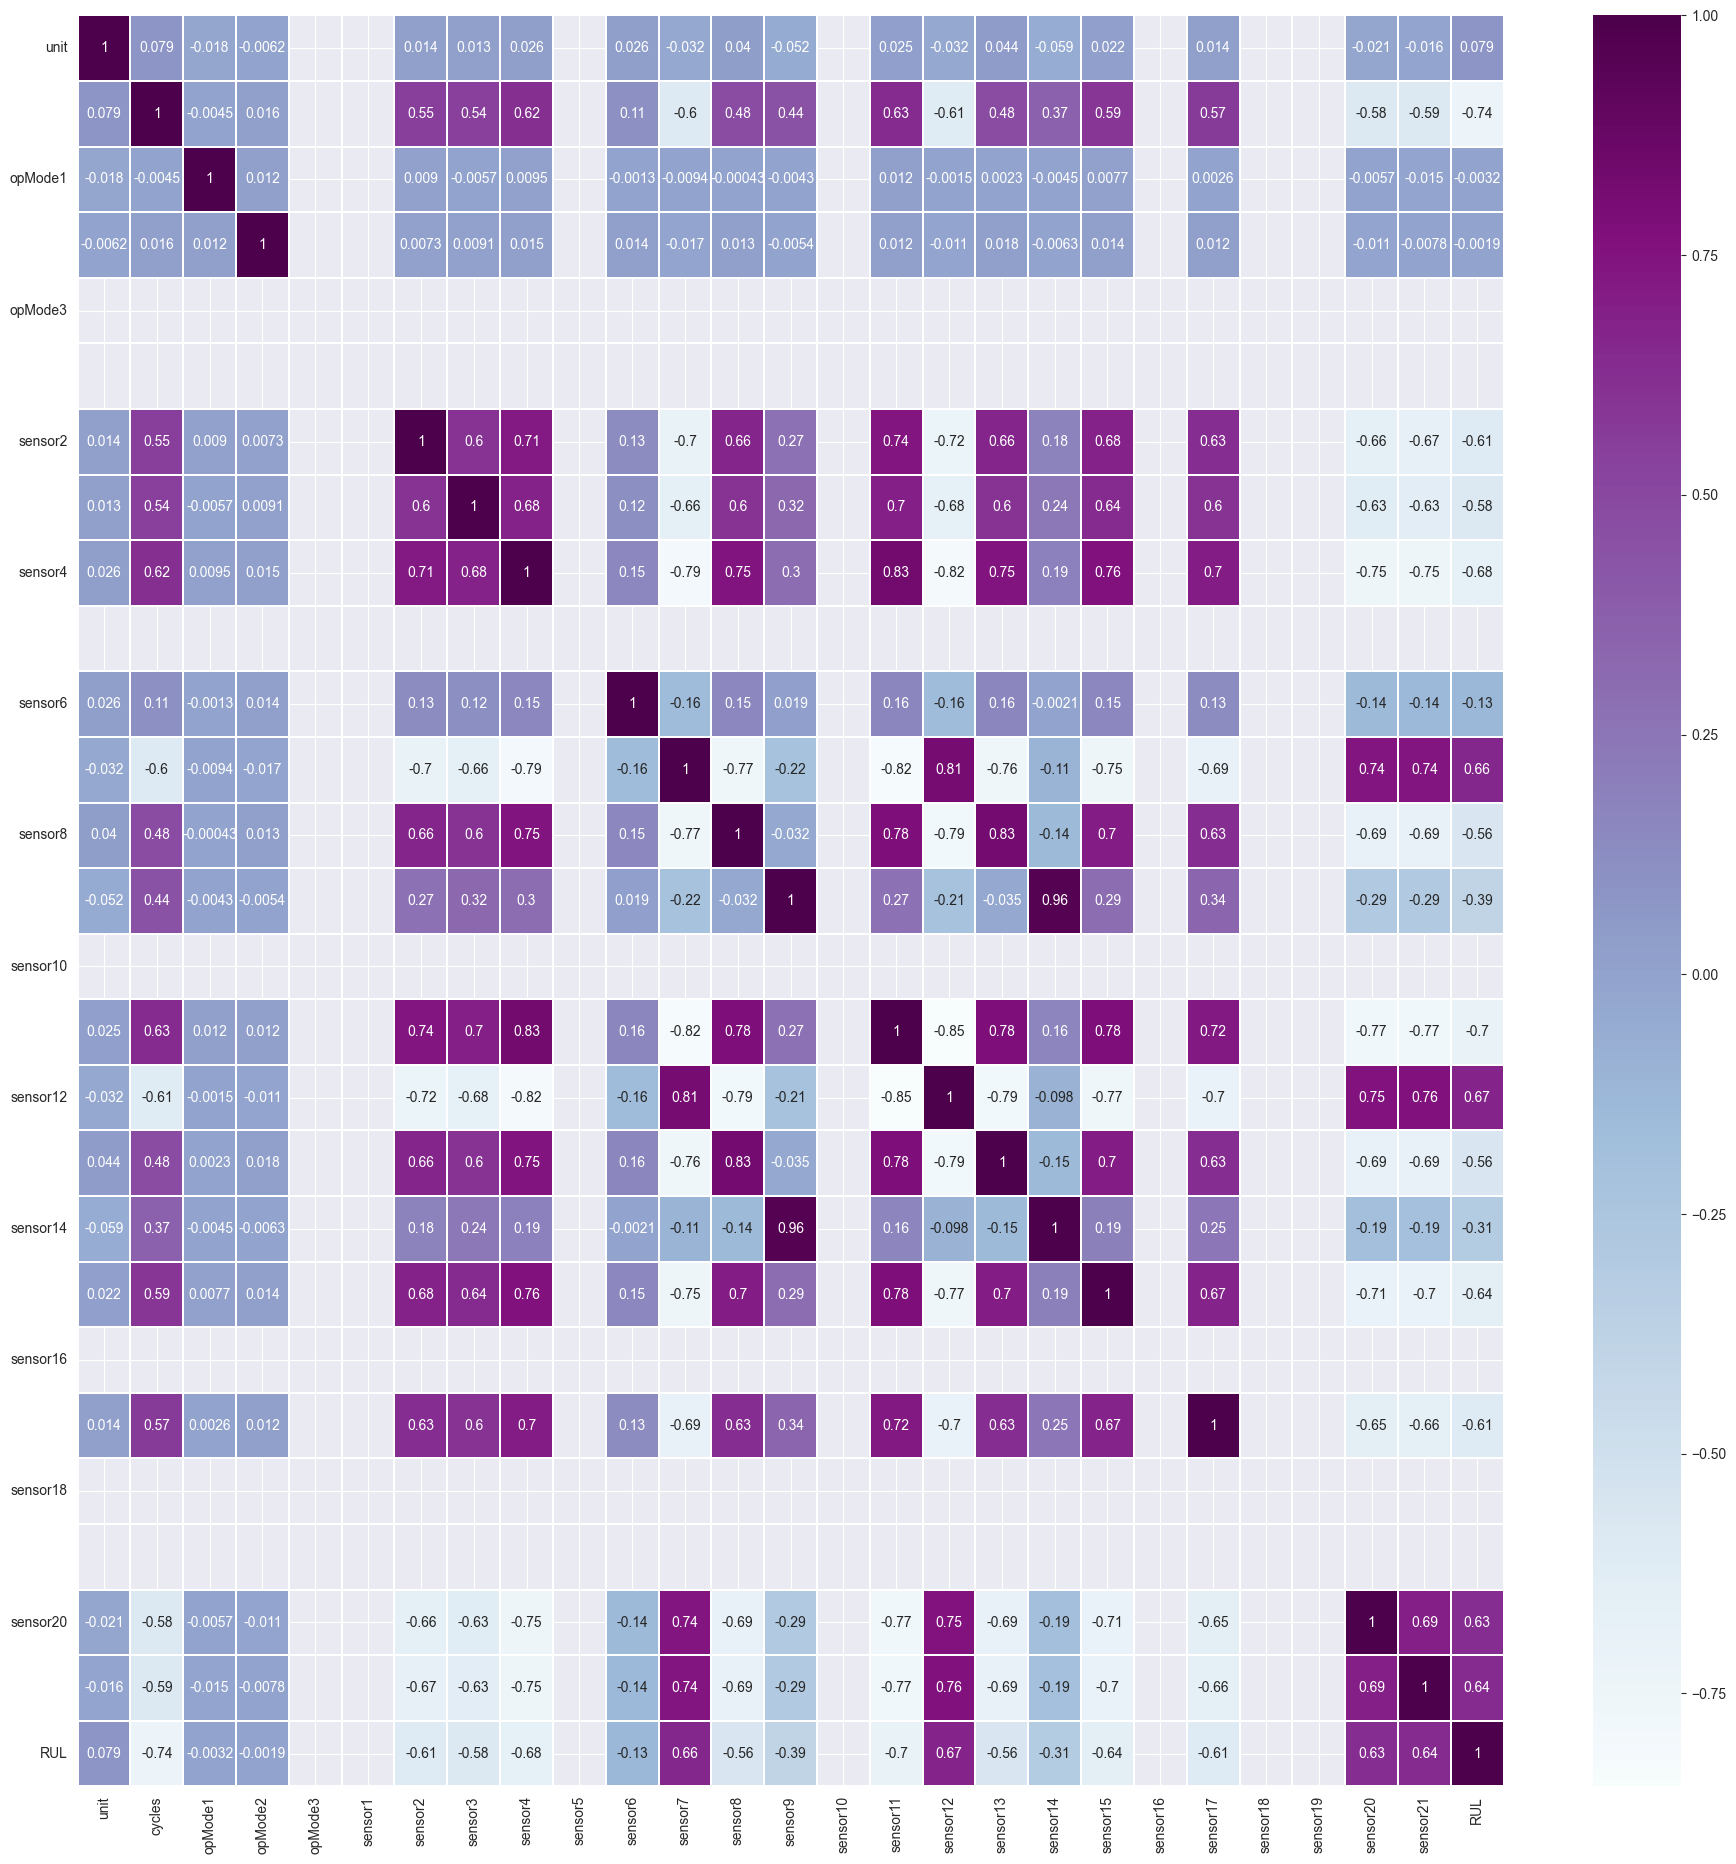

In [141]:
sns.heatmap(train_data[0].corr(), annot=True, cmap='BuPu', linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(23, 23)
plt.show()

In [13]:
"""Trajectories FD001 and FD003 both have redundant readings which can be dropped as they are constant or rarely change. FD004 and FD002 both have a redundant sensor 16."""
cols_to_drop = ['opMode3', 'sensor1', 'sensor5',
                'sensor6', 'sensor10', 'sensor16',
                'sensor18', 'sensor19', 'sensor17']

train_data[0].drop(columns=cols_to_drop, inplace=True)
train_data[2].drop(columns=cols_to_drop, inplace=True)
test_data[0].drop(columns=cols_to_drop, inplace=True)
test_data[2].drop(columns=cols_to_drop, inplace=True)

train_data[1].drop(columns=['sensor16'], inplace=True)
train_data[3].drop(columns=['sensor16'], inplace=True)

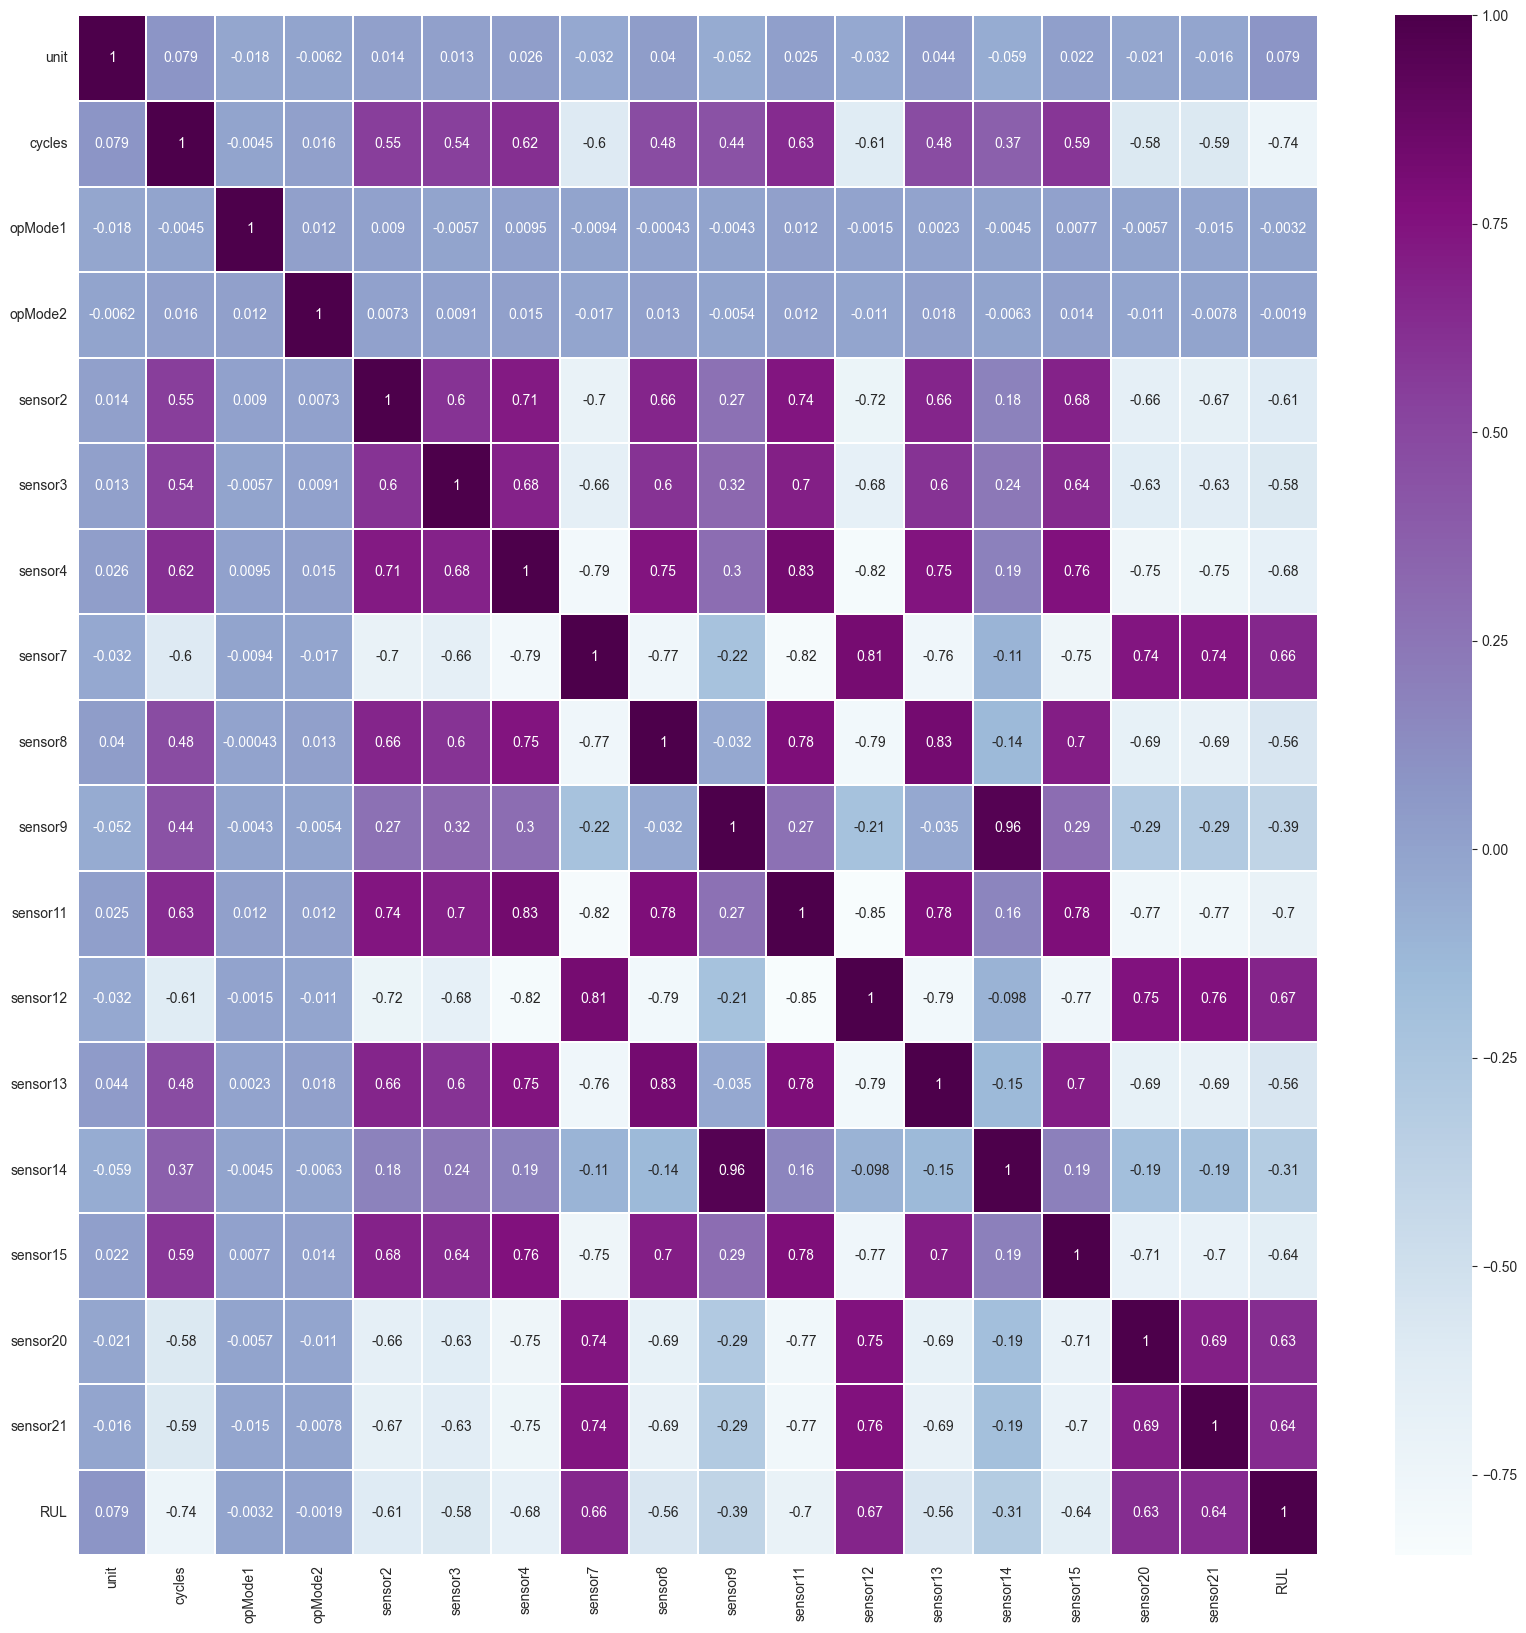

In [143]:
sns.heatmap(train_data[0].corr(), annot=True, cmap='BuPu', linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.show()

In [14]:
# Removing properties with weak correlation and high inter-correlation
# sensor 14 and has aa very high correlation with sensor 9, we can remove sensor 14 to reduce multicollinearity
train_data[0].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
test_data[0].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
train_data[2].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
test_data[2].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)

In [15]:
# Min-max scaling the data, except [cycles, RUL]
scaler = MinMaxScaler(feature_range=(-1, 1))

train_data[0].iloc[:, 2:-1] = scaler.fit_transform(train_data[0].iloc[:, 2:-1])
test_data[0].iloc[:, 2:] = scaler.transform(test_data[0].iloc[:, 2:])

train_data[2].iloc[:, 2:-1] = scaler.fit_transform(train_data[2].iloc[:, 2:-1])
test_data[2].iloc[:, 2:] = scaler.transform(test_data[2].iloc[:, 2:])

In [16]:
# Creating a training sequence
def create_training_sequence(df, seq_length, seq_cols):
    
    """function to prepare training data into (samples, time steps, features)
    df = training dataframe
    seq_length = look-back period
    seq_cols = feature columns"""

    data_array = df[seq_cols].values
    num_elements = data_array.shape[0]
    # issue is on line 74; num_elements is 1 and the for loop on line 80 has no effect because seq_length > num_elements

    lstm_array = []

    for start, stop in zip(range(0, num_elements - seq_length + 1), range(seq_length, num_elements + 1)):
        lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)

def create_target_sequence(df, seq_length, label):
    data_array = df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length - 1:num_elements + 1]


def create_training_batch(df, seq_length, columns):
    """Since the test data is stopped some arbitrary time before failure,
       the number of engine cycles won't necessarily be longer than a given window length,
       so we generate testing sequences which meet the sequence_length 
       """
    x = np.concatenate(
        list(list(create_training_sequence(df[df['unit'] == i], seq_length, columns)) for i in df['unit'].unique()))
    y = np.concatenate(
        list(list(create_target_sequence(df[df['unit'] == i], seq_length, 'RUL')) for i in df['unit'].unique()))
    return x, y


In [17]:
FD_columns = [[column for column in df if column != 'RUL'] for df in train_data]

In [18]:
sequence_length = 10
trajectory = 0  # see readme file
batch_size = 64
FD001_train = train_data[trajectory]
FD001_test = test_data[trajectory]
FD001_truth = RUL_data[trajectory]

In [19]:
a, b = create_training_batch(FD001_train, sequence_length, FD_columns[trajectory])

In [22]:
feature_count = a.shape[2]
out_dim = 1  # output dimension (1 RUL value)


In [23]:
x_train, x_val, y_train, y_val = train_test_split(a, b, test_size=0.25, random_state=42)

train_dataset = TensorDataset(torch.tensor(x_train).float(),
                              torch.tensor(y_train).float().unsqueeze(1))
val_dataset = TensorDataset(torch.tensor(x_val).float(),
                            torch.tensor(y_val).float().unsqueeze(1))

In [24]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [25]:
# Using the ground truth labels to create an RUL column in the test data
rul = pd.DataFrame(FD001_test.groupby('unit')['cycles'].max()).reset_index()
rul.columns = ['unit', 'max']
FD001_truth.columns = ['rulTruth']
FD001_truth['unit'] = np.arange(1, len(rul) + 1, 1)  # 100 units
FD001_truth['startLife'] = rul['max'] + FD001_truth['rulTruth']  # 
FD001_truth.drop(columns=['rulTruth'], inplace=True)

In [26]:
FD001_test = FD001_test.merge(FD001_truth, on=['unit'], how='left')
FD001_test['RUL'] = FD001_test['startLife'] - FD001_test['cycles']
FD001_test.drop('startLife', axis=1, inplace=True)

# Model Creation

We use an LSTM model to capture the long-term dependencies in the time series data.

In [130]:
# Defining LSTM class
class DamagePropagationLSTM(nn.Module):
    def __init__(self, feature_count, out_dim):
        super(DamagePropagationLSTM, self).__init__()
        # Convolutional block
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=feature_count, out_channels=64,kernel_size=3, padding=1),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU()
        )
        
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True, bidirectional=True)
        self.batch_norm = nn.BatchNorm1d(num_features=128)
        self.dropout1 = nn.Dropout(0.1)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(0.2)
        self.dense2 = nn.Linear(in_features=256, out_features=out_dim)
        self.activation2 = nn.LeakyReLU()

    def forward(self, x):
        #x = self.conv1(x.transpose(1, 2)).transpose(1, 2)
        #x = self.maxpool1d(x)
        #x = self.flatten(x)
        #x = self.dense1(x)
       #x = self.activation1(x)
        
        x = self.cnn(x.transpose(1, 2)).transpose(1, 2)
        x, _ = self.lstm1(x)
        x = self.batch_norm(x.transpose(1, 2)).transpose(1, 2)
        x = self.dropout1(x)
        x, (hn, cn) = self.lstm2(x)
        x = self.dropout2(hn[-1])
        x = self.dense2(x)
        x = self.activation2(x)
        return x
       
   

In [131]:
# training function
def train_model(model, criterion, optimizer, 
                scheduler, train_loader, val_loader, 
                num_epochs=60, patience=20, filename='unnamed_model.pt'):
    best_loss = float('inf')
    patience_counter = 0
    print("Model initialised successfully. Beginning training on {dev}...".format(dev=torch.cuda.get_device_name(0)))
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data).to(device)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * data.size(0)
        
       

        epoch_train_loss = epoch_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data).to(device)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item() * data.size(0)

        epoch_val_loss = epoch_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        scheduler.step(epoch_val_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
        
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), filename)
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping!')
            break
    return train_losses, val_losses



In [132]:
Model = DamagePropagationLSTM(feature_count, out_dim).to(device)
print("----- Model Summary -----\n", Model, "\n----- ----- -----\n")

----- Model Summary -----
 DamagePropagationLSTM(
  (cnn): Sequential(
    (0): Conv1d(14, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (lstm1): LSTM(64, 64, batch_first=True, bidirectional=True)
  (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (lstm2): LSTM(128, 256, batch_first=True, bidirectional=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dense2): Linear(in_features=256, out_features=1, bias=True)
  (activation2): LeakyReLU(negative_slope=0.01)
) 
----- ----- -----



In [133]:
# Loss criterion
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(Model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

In [134]:
model_filename = 'LSTM_model4.pt'
model_path = f'E:/ML/NeurIPS2024/pmh/{model_filename}'
#model_path = f'D:/DataScience/CMAPSS/code/tft_new_311/{model_filename}'

In [135]:
epochs = 60
model1 = train_model(Model, criterion, optimizer, scheduler,
                     train_loader, val_loader, num_epochs=epochs, 
                     patience=15, filename=model_filename)

Model initialised successfully. Beginning training on NVIDIA GeForce RTX 3070...
Epoch 1/45, Training Loss: 9061.3635, Validation Loss: 5698.4182
Epoch 2/45, Training Loss: 4029.0893, Validation Loss: 2855.1807
Epoch 3/45, Training Loss: 2388.2761, Validation Loss: 1950.7142
Epoch 4/45, Training Loss: 1775.4146, Validation Loss: 1680.1630
Epoch 5/45, Training Loss: 1523.6505, Validation Loss: 1664.3191
Epoch 6/45, Training Loss: 1413.3489, Validation Loss: 1341.8887
Epoch 7/45, Training Loss: 1330.4036, Validation Loss: 1244.6495
Epoch 8/45, Training Loss: 1291.0988, Validation Loss: 1225.1352
Epoch 9/45, Training Loss: 1259.6019, Validation Loss: 1254.6941
Epoch 10/45, Training Loss: 1244.8091, Validation Loss: 1348.2485
Epoch 11/45, Training Loss: 1237.3242, Validation Loss: 1167.4327
Epoch 12/45, Training Loss: 1208.6278, Validation Loss: 1178.8748
Epoch 13/45, Training Loss: 1194.6672, Validation Loss: 1124.5384
Epoch 14/45, Training Loss: 1189.3683, Validation Loss: 1469.8520
Epoc

# Model performance

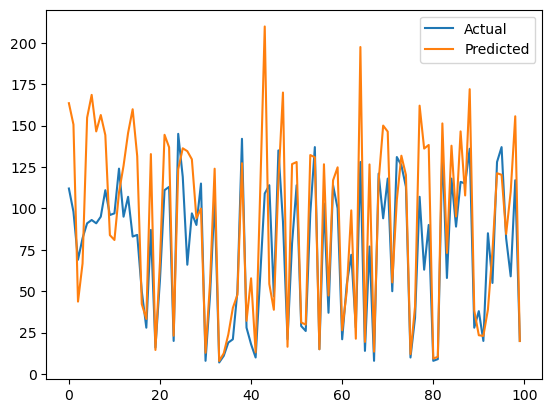

In [143]:
a1a1 = np.array([112,  98,  69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,
       107,  83,  84,  50,  28,  87,  16,  57, 111, 113,  20, 145, 119,
        66,  97,  90, 115,   8,  48, 106,   7,  11,  19,  21,  50, 142,
        28,  18,  10,  59, 109, 114,  47, 135,  92,  21,  79, 114,  29,
        26,  97, 137,  15, 103,  37, 114, 100,  21,  54,  72,  28, 128,
        14,  77,   8, 121,  94, 118,  50, 131, 126, 113,  10,  34, 107,
        63,  90,   8,   9, 137,  58, 118,  89, 116, 115, 136,  28,  38,
        20,  85,  55, 128, 137,  82,  59, 117,  20])

b1b1 = np.array([163.49804845, 150.6297164 ,  43.74402118,  66.79577026,
       154.74367985, 168.5031822 , 146.46199203, 156.3521716 ,
       144.24781045,  83.85893308,  80.93237902, 109.59312809,
       125.75106445, 145.60742262, 159.82878256, 131.50587088,
        42.29623121,  33.27971224, 132.77339986,  14.56121457,
        67.81602269, 144.41929239, 136.8713975 ,  23.15862001,
       123.61828274, 136.27118382, 134.52928495, 129.62922007,
        94.09970978,  99.89925063,  12.86784792,  55.67670673,
       123.95558757,   7.91279563,  12.52594915,  23.90578593,
        39.95096639,  47.84679027, 127.26004955,  32.14457369,
        57.80727217,  13.09245063, 110.02765873, 209.79415852,
        54.39388973,  38.81556962, 116.32961723, 169.92907834,
        16.48404145, 126.73669559, 127.98196495,  31.14876488,
        29.87130567, 132.18279365, 130.86696914,  14.98835941,
       126.62889403,  47.41069424, 116.93060553, 124.79491198,
        26.43226388,  49.87899485,  98.79869571,  21.34399813,
       197.39590365,  19.42110132, 126.53697222,  13.54209179,
       116.36515301, 149.9781087 , 146.3351692 ,  55.33820231,
       105.14879912, 131.78100154, 120.18539488,  12.0635106 ,
        40.73304409, 162.00071496, 136.09689388, 138.28168285,
         9.37877846,  10.39583558, 151.28357264,  73.1166532 ,
       137.83175659,  95.10156494, 146.47625798, 107.79583299,
       171.94724828,  38.40000646,  23.42848432,  23.04123251,
        38.90825529,  74.21453997, 121.2230548 , 120.28682733,
        84.54232717, 109.99097177, 155.59606525,  19.93116298])

plt.plot(a1a1, label='Actual')
plt.plot(b1b1, label='Predicted')
plt.legend()
plt.show()

In [136]:
ModelTest = DamagePropagationLSTM(feature_count, out_dim).to(device)
ModelTest.load_state_dict(torch.load(model_path))
ModelTest.eval()

DamagePropagationLSTM(
  (cnn): Sequential(
    (0): Conv1d(14, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (lstm1): LSTM(64, 64, batch_first=True, bidirectional=True)
  (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (lstm2): LSTM(128, 256, batch_first=True, bidirectional=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (dense2): Linear(in_features=256, out_features=1, bias=True)
  (activation2): LeakyReLU(negative_slope=0.01)
)

In [137]:
# expects a tuple of training and validation losses from line 195
def loss_graphs(model):
    e = range(1, len(model[0]) + 1)  # the lists in the tuple are of equal length, can be model[1]
    plt.figure(figsize=(10,5))
    plt.plot(e, model[0], 'b', label='Training loss')
    plt.plot(e, model[1], 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()

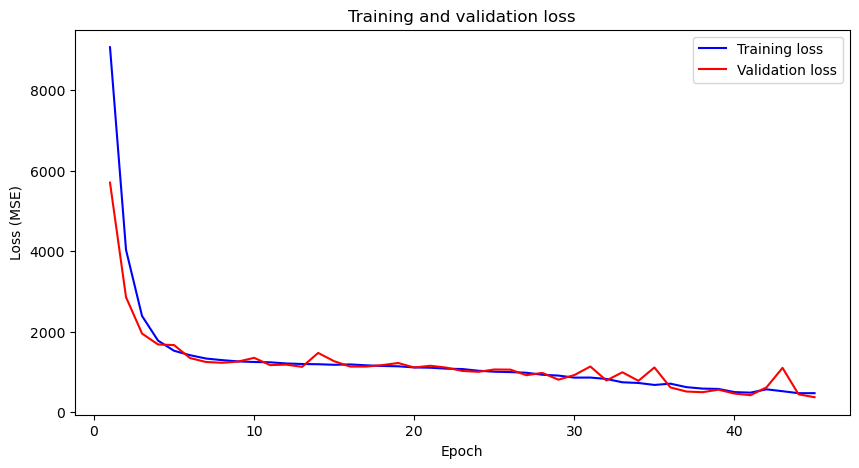

In [138]:
loss_graphs(model1)

In [127]:
# Preparing data for training evaluation
x_train_tensor = torch.tensor(x_train).float().to(device)

with torch.no_grad():
    y_train_pred = ModelTest(x_train_tensor)
    
y_train_pred = y_train_pred.cpu().numpy()
y_train_tensor = torch.tensor(y_train).float().unsqueeze(1).cpu().numpy()

### Model evaluation on validation data

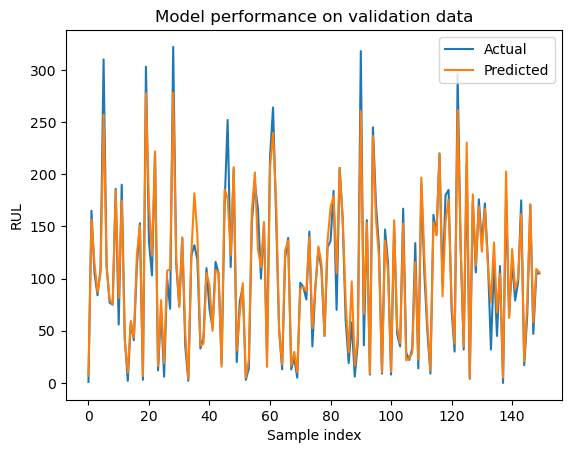

In [139]:
plt.plot(y_train[0:150], label='Actual')
plt.plot(y_train_pred[0:150], label='Predicted')
plt.title('Model performance on validation data')
plt.xlabel('Sample index')
plt.ylabel('RUL')
plt.legend()
plt.show()

# Preparing test data

In [40]:
test_cols = list(FD001_test.columns[:-1])
x_test = create_training_sequence(FD001_test, sequence_length, test_cols)
x_test_tensor = torch.tensor(x_test).float().to(device)



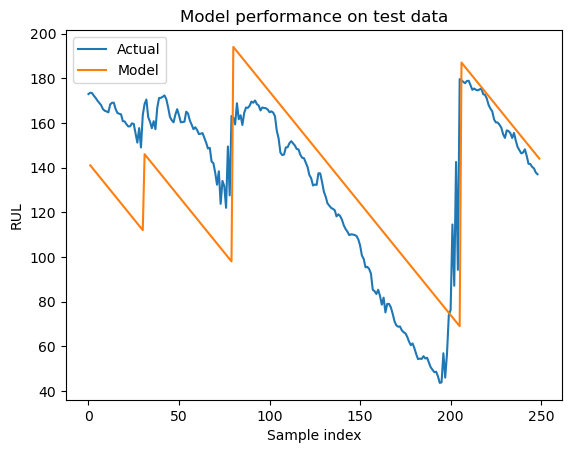

In [140]:
ModelTest.eval()
with torch.no_grad():
    y_test_pred = ModelTest(x_test_tensor)
    
y_test_pred = torch.Tensor.cpu(y_test_pred)

plt.plot(y_test_pred[1:250], label='Actual')
plt.plot(FD001_test['RUL'][1:250], label='Model')
plt.xlabel('Sample index')
plt.ylabel('RUL')
plt.title("Model performance on test data")
plt.legend()
plt.show()

In [116]:
# Score evaluation

Exploring the uses of dropout layers in recurrent architectures and how to optimise them.
[1] https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7333848&tag=1
Convolutional layer adjustment
[2] https://arxiv.org/pdf/1603.07285v1